# Alzheimer's Disease classification from anatomical MRI

## Exploring the classification of different imaging features using a random forest model
(Code deployed in Jupyter notebook using a PySpark kernel leveraging Apache Hadoop)

In [1]:
# import analysis and plotting libraries

# "standard"
import numpy as np
import pandas as pd

# machine learning
import pyspark
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import cv2

In [ ]:
# import pyspark module
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Brad's PySpark").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

In [3]:
# load training data
BASE_DIR = "C:/Users/bedelman/Documents\GitHub/Alzheimers-MRI-Classification/Alzheimer_MRI_Dataset/Data/"

'''
Label meanings
0 - Mild dementia
1 - Moderate dementia
2 - No dementia
3 - Very mild dementia
'''
Lab = ['Mild', 'Moderate', 'None', 'Very Mild']

train = pd.read_parquet(f"{BASE_DIR}/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [5]:
# Convert data to readable format

def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")

train['img_arr'] = train['image'].apply(dict_to_image)
train.drop("image", axis=1, inplace=True)
train.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [7]:
# Load test data

test = pd.read_parquet(f"{BASE_DIR}/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")
test.head() 

# Also convert to readable format
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)
test.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


Text(0, 0.5, '# of images')

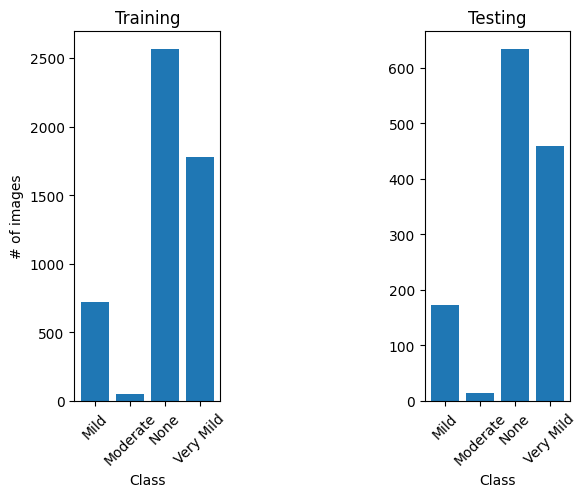

In [9]:
# what is the distribution of the datasets (are all classes represented equally?)

f, ax = plt.subplots(1,3)
unique, counts = np.unique(np.asarray(train.iloc[:].label), return_counts = True)
ax[0].bar(unique, counts)
ax[0].set_xticks(unique)
ax[0].set_xticklabels(Lab, rotation = 45)
ax[0].set_title('Training')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('# of images')

ax[1].axis('off')

unique, counts = np.unique(np.asarray(test.iloc[:].label), return_counts = True)
ax[2].bar(unique, counts)
ax[2].set_xticks(unique)
ax[2].set_xticklabels(Lab, rotation = 45)
ax[2].set_title('Testing')
ax[2].set_xlabel('Class')
ax[0].set_ylabel('# of images')

# An obvious imbalance across classes, but each class seems to be balanced across training/testing sets

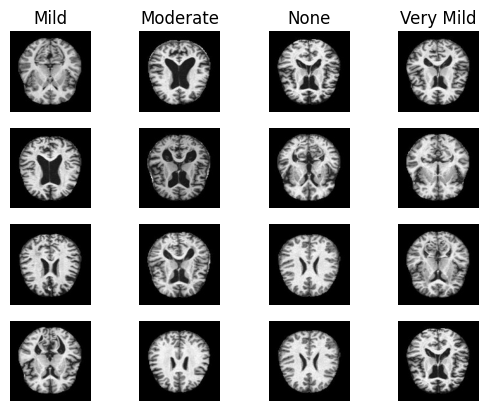

In [536]:
# visually inspect some of the data

train_lab_idx = np.asarray(train.iloc[:].label)

f, ax = plt.subplots(4,4)
for lab in range(4):
    for ex in range(4):
    
        class_lab = np.argwhere(train_lab_idx == 1)
        current_idx = np.random.randint(len(class_lab)-1,size = 1)
        current_idx = np.asarray(current_idx)
        
        ax[ex, lab].axis('off')
        ax[ex, lab].imshow(train.iloc[class_lab[current_idx[0]][0]].img_arr, cmap = "gray")
        if ex == 0: ax[ex, lab].set_title(Lab[lab])

# Clearly, images show different slices within the brain, which may be a major confound...

# Feature engineering for visualization and classification

- raw pixel intensity X PCA
- histogram of oriented gradients
- segmented brain volume


Text(0, 0.5, 'Variance Explained')

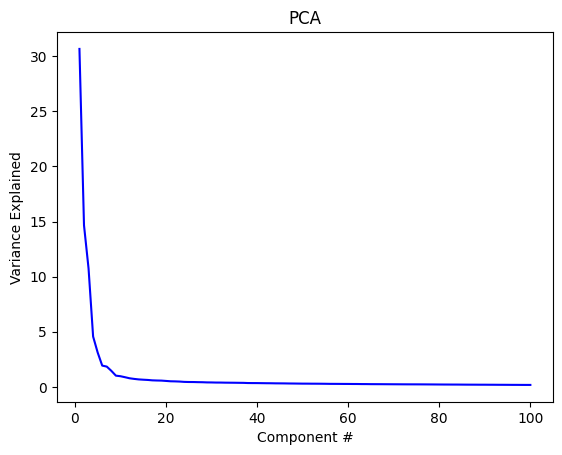

In [538]:
# PCA on raw pixel data

train_data = []
for i in range(len(train)):
    train_data.append(np.reshape(train.iloc[i].img_arr, (1, -1)))    
train_data = np.vstack(train_data[:])

# decompose with PCA and look at various metrics/info
pca = PCA(n_components = 100)
pca.fit(train_data)

plt.plot(np.linspace(1,100,100),pca.explained_variance_[:100]/sum(pca.explained_variance_[:100])*100,'b')
plt.title('PCA')
plt.xlabel('Component #')
plt.ylabel('Variance Explained')

Text(0, 0.5, 'PC 2')

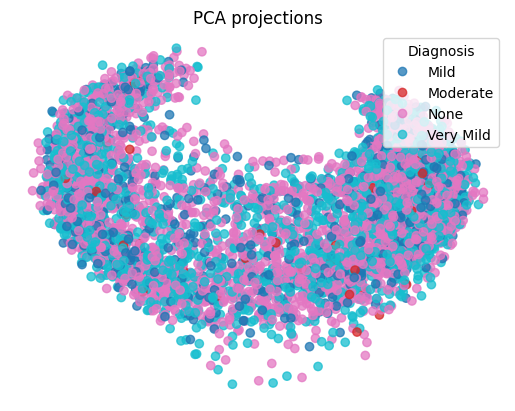

In [539]:
# Project training data into PCA space to visualize potential clustering
## first two PC's for simple visualization

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
load_train = np.matmul(train_data, loadings[:,:2])

# plot first two PCs
s  = plt.scatter(load_train[:,0], load_train[:,1], c = train_lab_idx*2, cmap = 'tab10', alpha = 0.75)
handles, labels = s.legend_elements()
legend = plt.legend(handles = handles, labels = Lab, title = 'Diagnosis', loc = 'upper right')
plt.axis('off')
plt.title('PCA projections')
plt.xlabel('PC 1')
plt.ylabel('PC 2')


In [542]:
# Train random forest classifier and apply to test data
## for now again only with first two PCs

rf_1 = RandomForestClassifier()

# Train classifier
load_train = np.matmul(train_data, loadings[:,:2])
rf_1.fit(load_train, train_lab_idx)

# Properly format test data and extract same features (PC loadings)
test_data = []
for i in range(len(test)):
    test_data.append(np.reshape(test.iloc[i].img_arr, (1, -1)))    
test_data = np.vstack(test_data[:])

load_test = np.matmul(test_data, loadings[:,:2])

# Predict unseen data
predictions_1 = rf_1.predict(load_test)
test_lab_idx = np.asarray(test.iloc[:].label)

# compare predictions with test labels and compute accuracy
result = predictions_1 - test_lab_idx
result_binary = np.argwhere(result == 0)
correct = np.size(result_binary,0)
acc = correct/test_lab_idx.shape[0]*100
print(acc)

# When using the top two PCs, we see a modest classification rate on the test set. 
## However, using two PC's here is arbitrary due to easy visualization purposes.
## We can also exmaine accuracy as a function of the number of PCs and visualize the PC loading maps to interpret the classification results

43.59375

(30.0, 60.0)

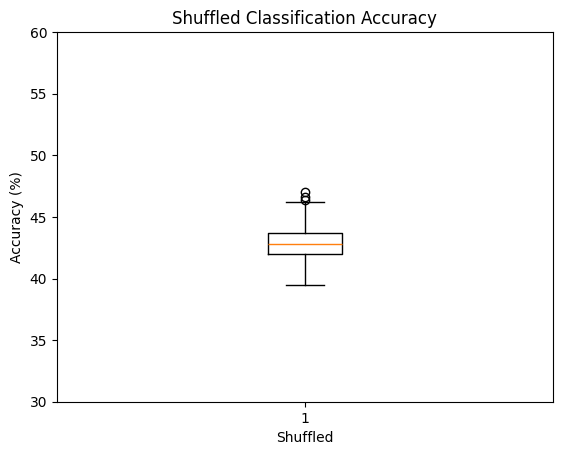

In [544]:
# Let's also shuffle data labels in the train set to evaluate "chance" level 
## we'll do this a number of times to generate a sufficient null distribution

test_lab_idx = np.asarray(test.iloc[:].label)
train_lab_idx_shuffle = train_lab_idx
load_train = np.matmul(train_data, loadings[:,:2])

rng = np.random.default_rng()

acc_shuffle = []
for i in range(500):

    # Train classifier with new shuffled labels each iteration
    rf_1 = RandomForestClassifier()
    rng.shuffle(train_lab_idx_shuffle)
    rf_1.fit(load_train, train_lab_idx_shuffle)

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)

    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    acc_shuffle = np.append(acc_shuffle, acc)

b = plt.boxplot(acc_shuffle)
plt.title('Shuffled Classification Accuracy')
plt.xlabel('Shuffled')
plt.ylabel('Accuracy (%)')
plt.ylim(30, 60)

In [550]:
# Determine significance of previous classification accuracy

null_above_value = (acc_shuffle > acc).sum()
p_value = null_above_value/np.size(acc_shuffle,0)
print(p_value)

# We can see here that the classification accuracy is not sigificcantly different from chance with p-value > 0.05

0.528


In [ ]:
# Now lets look at the test set classification as a function of PCs

acc_tot = []
for i in range(1, np.size(loadings,1)):

    load_train = np.matmul(train_data, loadings[:,:i])

    rf_1 = RandomForestClassifier()
    rf_1.fit(load_train, train_lab_idx)
    
    load_test = np.matmul(test_data, loadings[:,:i])

    # Predict unseen data
    predictions_1 = rf_1.predict(load_test)
    test_lab_idx = np.asarray(test.iloc[:].label)
    
    # compare predictions with test labels and compute accuracy
    result = predictions_1 - test_lab_idx
    result_binary = np.argwhere(result == 0)
    correct = np.size(result_binary,0)
    acc = correct/test_lab_idx.shape[0]*100
    acc_tot = np.append(acc_tot, acc)

# plot accuracy as a function of PCs
plt.plot(np.linspace(1,np.size(loadings,1)-1,np.size(loadings,1)-1),acc_tot,'k')
plt.title('Classification accuracy')
plt.xlabel('Component #')
plt.ylabel('Accuracy (%)')


In [574]:
# also perform permutation testing for each number of PC to determine statistical significance
## permutations take time so lets parallelize this to save a bit



99

In [ ]:
# Visualize PC's to identify spatial features that contribute to data variance and subsequent classification

f, ax = plt.subplots(5,4)
lim = 20
for ipc in range(lim):

    PC_map = loadings[:,ipc]
    PC_map = np.reshape(PC_map, (128,128))
    clim = max(abs(np.min(PC_map)), abs(np.max(PC_map)))

    idx1 = np.floor(ipc/4).astype(int)
    idx2 = np.fmod(ipc,4)
    ax[idx1, idx2].axis('off')
    ax[idx1, idx2].imshow(PC_map, cmap = "magma", vmin = -clim, vmax = clim)
    ax[idx1, idx2].set_title(f'PC# {ipc +1}', fontsize = 10)
    plt.tight_layout()
    
    
